# 第7章 EM アルゴリズム：最尤推定法による教師なし学習（自習書き込み用）

## 「07-mix_em.py」の解説

ITエンジニアための機械学習理論入門「第7章 EMアルゴリズム:最尤推定法による教師なし学習」で使用しているサンプルコード「07-mix_em.py」の解説です。

※ 解説用にコードの内容は少し変更しています。

はじめに必要なモジュールをインポートしておきます。

特に、画像データを扱うためにPILモジュールを利用します。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import randint, rand

import matplotlib
matplotlib.rcParams['font.size'] = 12

手書き画像データファイルをダウンドードして、展開しておきます。

In [2]:
!curl -OL https://github.com/enakai00/jupyter_ml4se/raw/master/train-images.txt.gz
!curl -OL https://github.com/enakai00/jupyter_ml4se/raw/master/train-labels.txt.gz
!ls train-*.txt.gz 2>/dev/null && gzip -fd train-*.txt.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   149  100   149    0     0   3386      0 --:--:-- --:--:-- --:--:--  3386
100 12.6M  100 12.6M    0     0  61.0M      0 --:--:-- --:--:-- --:--:-- 61.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   149  100   149    0     0   3921      0 --:--:-- --:--:-- --:--:--  3921
100 32764  100 32764    0     0   457k      0 --:--:-- --:--:-- --:--:--  457k
train-images.txt.gz  train-labels.txt.gz


展開されたデータファイルを確認します。

「tarin-images.txt」と「train-labels.txt」が用意されていることを確認してください。

In [3]:
ls -l train-*.txt

-rw-rw-r-- 1 a a 109455994 Jan 18 16:18 train-images.txt
-rw-rw-r-- 1 a a    120000 Jan 18 16:18 train-labels.txt


指定の数字の画像を抽出して、モノクロ２階調に変換する関数を用意します。

In [4]:
import re
from subprocess import Popen, PIPE

def prep_data(Num=600, Chars='[036]'):
    labels = open('train-labels.txt', 'r')
    images = open('train-images.txt', 'r')
    labels_out = open('sample-labels.txt', 'w')
    images_out = open('sample-images.txt', 'w')
    chars = re.compile(Chars)

    while True:
        label = labels.readline()
        image = images.readline()
        if (not image) or (not label):
            break
        if not chars.search(label):
            continue
    
        line = ''
        for c in image.split(" "):
            if int(c) > 127:
                line += '1,'
            else:
                line += '0,'
        line = line[:-1]
        labels_out.write(label)
        images_out.write(line + '\n')
        Num -= 1
        if Num == 0:
            break
    
    labels.close()
    images.close()
    labels_out.close()
    images_out.close()

0, 3, 6に対応する画像を全部で600枚抽出します。

In [5]:
prep_data(600, '[036]')

抽出した結果は、ファイル「sample-images.txt」として保存されます。

In [6]:
!ls -l sample-images.txt

-rw-rw-r-- 1 a a 940800 Jan 18 16:18 sample-images.txt


このデータを用いて、EM法の繰り返し処理を1回分だけ実施する関数を用意します。

In [7]:
# ベルヌーイ分布
def bern(x, mu):
    r = 1.0
    for x_i, mu_i in zip(x, mu):
        if x_i == 1:
            r *= mu_i 
        else:
            r *= (1.0 - mu_i)
    return r

# Main
def run_em(mix, mu):
    # トレーニングセットの読み込み
    df = pd.read_csv('sample-images.txt', sep=",", header=None)
    data_num = len(df)

    # E phase
    resp = DataFrame()
    for index, line in df.iterrows():
        #lineはサンプル画像の１文字分らしい(size=784=28*28になるため)
        #print("line: index=", index, "size= ", len(line), "line= ", line)
        tmp = []
        for k in range(K):
            #bern(line, mu[k])で、画像製造器μkがline(画像の１つ）を生成する確率を求める　式 7.10に相当
            #さらに、画像生成器を選択する確率πkを掛け、式7.12の計算結果をaとしている。
            a = mix[k] * bern(line, mu[k])
            # 式7.15のrnkを計算する。a/sより、aが0の場合は即座にrnkの計算結果は０
            if a == 0:
                tmp.append(0.0)
            else: # aが0以外の時の、式7.15のrnkを計算する。
                s = 0.0
                for kk in range(K):
                    s += mix[kk] * bern(line, mu[kk])
                tmp.append(a/s)
        resp = resp.append([tmp], ignore_index=True)

    #respの構造(resp=rnk 式7.15)
    #   0         1         2
    #0  0.000000  0.000000  0.000000
    #1  0.000000  0.000000  0.000000
    #2  0.694444  0.011905  0.293651
    #...599まで同様
    #各画像毎が各画像製造器から生成される確率が格納されている
        
    #respのlenがdfと同じく600となる([600 rows x 3 columns])  print(resp)
    # M phase
    # 式7.16と7.17を計算
    new_mu = np.zeros((K, 28*28))
    new_mix = np.zeros(K)
    for k in range(K):
        nk = resp[k].sum() #式7.17の分子(式7.16の分母でもある)。画像製造器k番目が、各画像を生成する確率の和。
        new_mix[k] = nk/data_num #式7.17を計算。data_numは画像の枚数(600枚)
        #新しいμkを計算(式 7.16)
        for index, line in df.iterrows(): #各画像をループ
            new_mu[k] += line * resp[k][index] #右辺が、式7.16の分子
        new_mu[k] /= nk
    
    cls = []
    for index, line in resp.iterrows():
        cls.append(np.argmax(line[0:])) #各画像にぴったりな画像製造器を選択（画像の生成確率が最大となる画像製造器を選択）
        #np.argmaxは配列の最大要素のインデックスを返す
        
    return new_mix, new_mu, cls

また、「代表文字」の画像を表示する関数を用意します。

In [8]:
def show_images(mu):
    fig = plt.figure()
    K = len(mu)
    for k in range(K):
        subplot = fig.add_subplot(1,K,k+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(mu[k].reshape(28,28), cmap=plt.cm.gray_r)

「代表文字」の画像を乱数で生成します。ここでは、例として、3枚の画像を用意します。

In [9]:
K=3
# 初期パラメータの設定
mix = [1.0/K] * K
#muは画像製造器μのこと。28*28サイズの画像を３つ作る
mu = (rand(28*28*K)*0.5+0.25).reshape(K, 28*28)
for k in range(K):
    mu[k] /= mu[k].sum() #さらに平滑化している　→　ここをコメントアウトしても実行結果は変わらない様子。なぜ、平滑化？

画像を表示すると次のようになります。ランダムな画像が用意されていることがわかります。

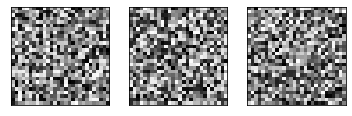

In [10]:
show_images(mu)

EM法の処理を1回実施して、「代表文字」の画像を更新します。

mixとmuがEM法で更新するパラメーターで、clsは（この段階での）画像データの分離結果を格納したリストになります。

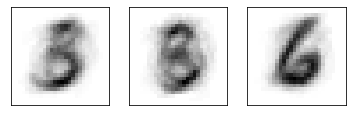

In [11]:
mix, mu, cls = run_em(mix, mu)
show_images(mu)

EM法の処理をさらに9回繰り返して、「代表文字」を更新していきます。

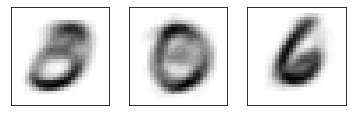

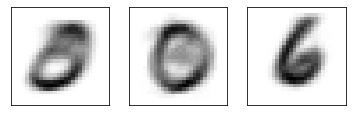

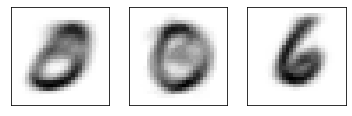

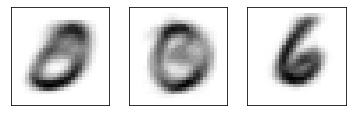

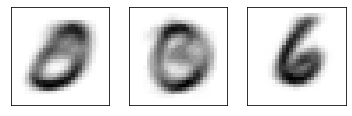

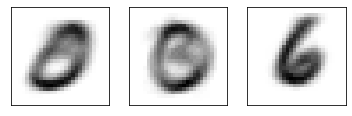

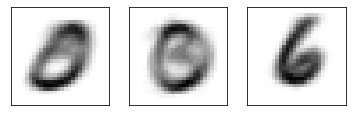

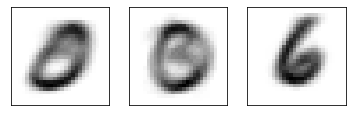

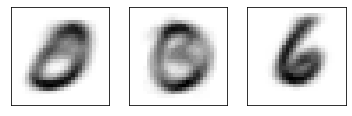

In [12]:
for i in range(9):
    mix, mu, cls = run_em(mix, mu)
    show_images(mu)

この段階での分類結果を可視化する関数を用意します。

In [13]:
def show_figure(mu, cls):
    K = len(mu)
    num = 6

    # トレーニングセットの読み込み
    df = pd.read_csv('sample-images.txt', sep=",", header=None)

    fig = plt.figure(figsize=(10, 5))
    for k in range(K):
        subplot = fig.add_subplot(K,num+1,1+k*(num+1))
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(mu[k].reshape(28,28), cmap=plt.cm.gray_r)

        i = 1
        for j in range(len(cls)):
            if cls[j] == k:
                subplot = fig.add_subplot(K,num+1,1+k*(num+1)+i)
                subplot.set_xticks([])
                subplot.set_yticks([])
                subplot.imshow(df.loc[j].values.reshape(28,28), cmap=plt.cm.gray_r)
                i += 1
                if i > num:
                    break

これを用いて結果を表示すると次のようになります。

各代表文字について、それに属するデータを6個ずつ表示しています。

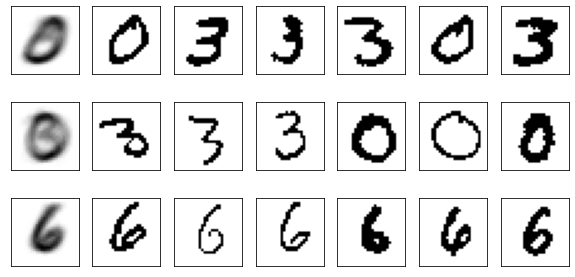

In [14]:
show_figure(mu, cls)

同様の処理を4個の代表文字で実施してみます。

In [15]:
K=4
# 初期パラメータの設定
mix = [1.0/K] * K
mu = (rand(28*28*K)*0.5+0.25).reshape(K, 28*28)
for k in range(K):
    mu[k] /= mu[k].sum()

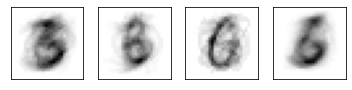

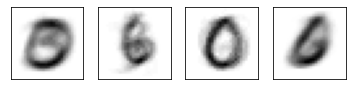

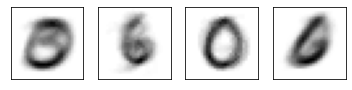

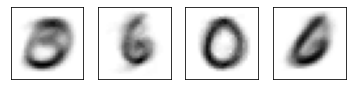

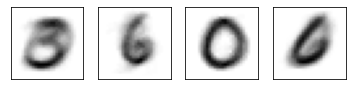

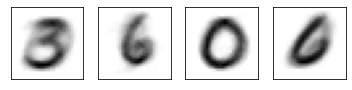

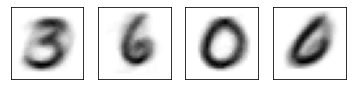

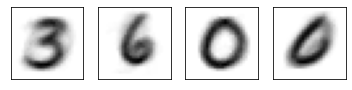

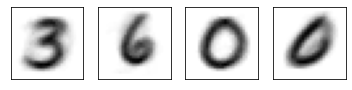

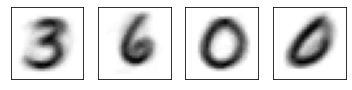

In [16]:
for i in range(10):
    mix, mu, cls = run_em(mix, mu)
    show_images(mu)

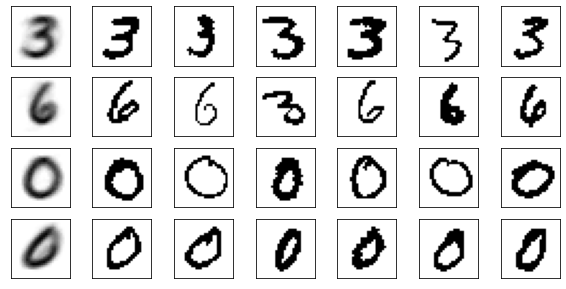

In [17]:
show_figure(mu, cls)